In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score as roc_auc_score
import matplotlib as mpl
import sys
from pathlib import Path

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [3]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

$
\begin{aligned}
& \frac{1}{T}\sum_{t, l} w_{t,l} A(c|\alpha_{t,l}) B_1(x_1|\beta_{t,l}) B_2(x_2|\gamma_{t,l}) \\
\end{aligned}
$

In [4]:
def process_data(file, y_labels, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, i]).flatten()
   
    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    elif ("r_x" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r_x", "a_x")

    #df["Confidence"] = data["confidence"]
    for i in range(len(y_labels)):
        df[f"Std_samples_{y_labels[i]}"] = np.std(np.array(data["samples"][:, :, i]), axis=-1)
    
    # Get truth label values (annoying because text is not read as text, should fix)
    # Is fixed, just update
    if (test == False):
        df["Truth_value"] = data["truth"]
        df["Truth"] = y_labels[0]
        blue = 1.0
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == blue
        df.loc[mask, "Truth"] = y_labels[1]
    
    # Get estimated probabilities
    for i in range(len(y_labels)):
        df[y_labels[i]] = data["probabilities"][:,i]
        df[f"P({y_labels[i]}|x)"] = data["probabilities"][:,i]

    # Get 25-75% error bars
    for i in range(len(y_labels)):
        df[f"quantile25_{y_labels[i]}"] = data["quantiles"][:, 1, i]
        df[f"quantile75_{y_labels[i]}"] = data["quantiles"][:, 2, i]
        df[f"Error_{y_labels[i]}"] = (df[f"quantile75_{y_labels[i]}"] - df[f"quantile25_{y_labels[i]}"])/2

    # Could be some NaNs
    len_nan = len(df[df.isnull().any(axis=1)])
    if len_nan > 0:
        print(f"Dropping {len_nan} rows of NaNs")
        df = df.dropna()

    # Get inferred color
    df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
    
    return df

In [5]:
# Custom plot function
def plot_distributions(df):

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), layout="constrained")

    # Plot 2D data points
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=axs[0][0])
    df_blue = df[df["color"] == "blue"]
    sn.scatterplot(df_blue, x="x1", y = "x2", c="blue", alpha=0.1, ax=axs[1][0])
    axs[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    axs[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot angular distribution
    sn.histplot(df_red, x="a_x", color="red", ax=axs[0][1])
    sn.histplot(df_blue, x="a_x", color="blue", ax=axs[1][1])
    axs[0][2].set_xlabel(r"$\theta_x$")
    axs[1][2].set_xlabel(r"$\theta_x$")

    # Plot radial distribution
    sn.histplot(df_red, x="r_x", color="red", ax=axs[0][2])
    sn.histplot(df_blue, x="r_x", color="blue", ax=axs[1][2])
    axs[0][2].set_xlabel(r"$|\vec{x}|$")
    axs[1][2].set_xlabel(r"$|\vec{x}|$")
    axs[0][2].set_xlim(0, 25)
    axs[1][2].set_xlim(0, 25)

    # Ticks
    for ax in axs.flatten():
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()

    return fig, ax

### Setup and constants

In [6]:
# Setup

#MCMC constants
n_samples = 1200
#n_data = [250, 500, 1000, 5000]
n_data = [500, 1000, 2000, 3000, 5000]
#n_data = [250, 2100, 3600, 5000]
n_chains = 10
n_plots = len(n_data)

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Data labels
y_labels = ["red", "blue"]
if polar:
    x_labels = ["r_x", "a_x"]
else:
    x_labels = ["x1", "x2"]

# Read files
folderpath = "inference"
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_200_nr1MC_200"
#testfile = f"test_n_10000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = "x1_x2_grid"

if polar:
    analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains}_ndata-{n_data[i]}_POLAR" for i in range(n_plots)]
else:
    analysis_folders = [f"{trainfile}/nsamples-{n_samples}_nchains-{n_chains}_ndata-{n_data[i]}" for i in range(n_plots)]
#valfiles = [f"{folderpath}/{folder}/{valfile}_inferred.h5" for folder in analysis_folders]
testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
gridfiles = [f"{folderpath}/{folder}/{gridfile}_inferred.h5" for folder in analysis_folders]
train_data = pd.read_csv(f"../data/{trainfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2]

grid_dfs = [process_data(file, y_labels, x_labels, test=True) for file in gridfiles]
test_dfs = [process_data(file, y_labels, x_labels, test=False) for file in testfiles]

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]


# Key to use for plotting
weight_key = f"P({y_labels[1]}|x)"

In [7]:
test_dfs[0]

,x1,x2,r_x,a_x,Std_samples_red,Std_samples_blue,Truth_value,Truth,red,P(red|x),blue,P(blue|x),quantile25_red,quantile75_red,Error_red,quantile25_blue,quantile75_blue,Error_blue,Inferred_color
0,4.637181,11.350187,12.260921,1.182936,0.120663,0.120663,0.0,red,0.504515,0.504515,0.495485,0.495485,0.414376,0.589257,0.087440,0.410743,0.585624,0.087440,red
1,10.042744,10.382106,14.444543,0.802012,0.120270,0.120270,0.0,red,0.564114,0.564114,0.435886,0.435886,0.473586,0.651992,0.089203,0.348008,0.526414,0.089203,red
2,-5.605532,11.920284,13.172515,2.010363,0.113849,0.113849,1.0,blue,0.682047,0.682047,0.317953,0.317953,0.598285,0.763957,0.082836,0.236043,0.401715,0.082836,red
3,-1.477669,-14.679668,14.753853,4.612066,0.138834,0.138834,1.0,blue,0.677693,0.677693,0.322307,0.322307,0.588388,0.775082,0.093347,0.224918,0.411612,0.093347,red
4,-9.945727,8.379890,13.005386,2.441433,0.111762,0.111762,1.0,blue,0.595980,0.595980,0.404020,0.404020,0.522951,0.678080,0.077565,0.321920,0.477049,0.077565,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.596807,9.253463,9.272689,1.506390,0.079133,0.079133,0.0,red,0.376708,0.376708,0.623292,0.623292,0.318014,0.434185,0.058085,0.565815,0.681986,0.058085,blue
9996,-6.404741,6.863661,9.387787,2.321621,0.121617,0.121617,1.0,blue,0.422282,0.422282,0.577718,0.577718,0.329478,0.517267,0.093895,0.482733,0.670522,0.093895,blue
9997,-11.277142,2.093363,11.469791,2.958053,0.114519,0.114519,1.0,blue,0.611469,0.611469,0.388531,0.388531,0.531289,0.693357,0.081034,0.306643,0.468711,0.081034,red
9998,8.927445,11.836816,14.825974,0.924606,0.126943,0.126943,0.0,red,0.594451,0.594451,0.405549,0.405549,0.498874,0.690546,0.095836,0.309454,0.501126,0.095836,red


### Plot training data and distributions

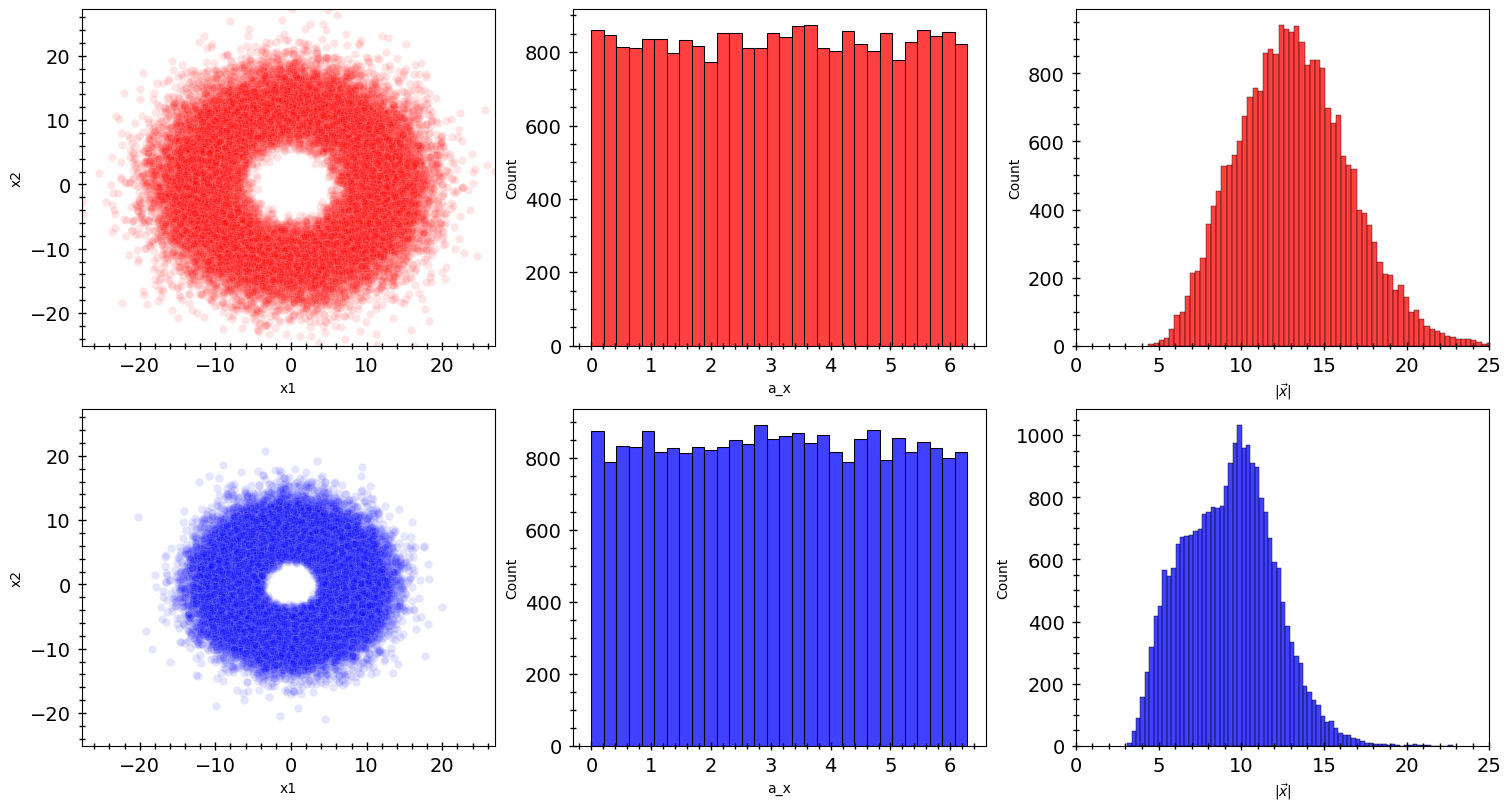

In [8]:
fig, ax = plot_distributions(train_data)

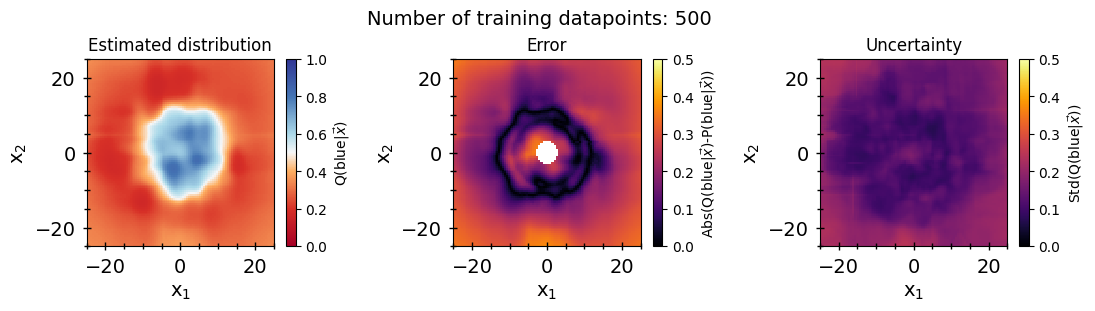

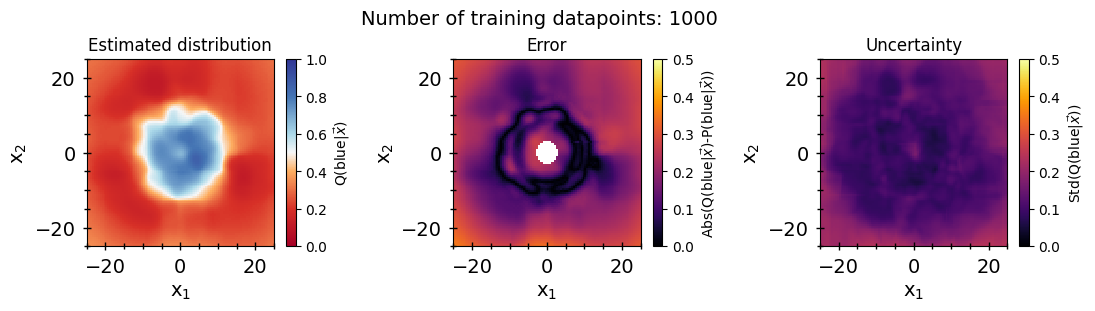

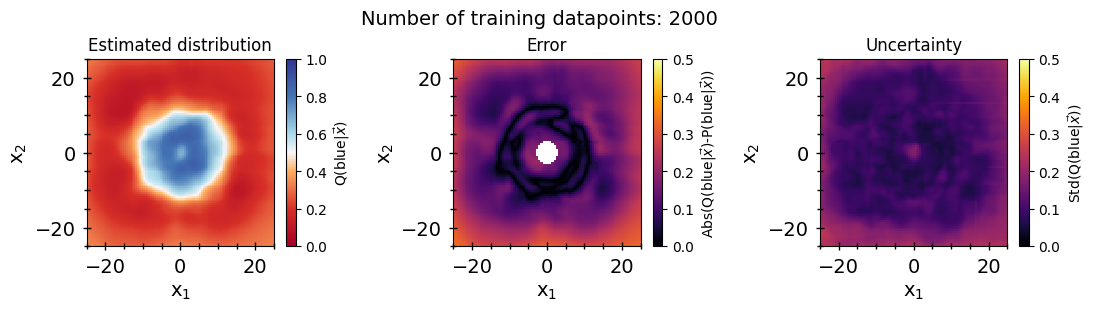

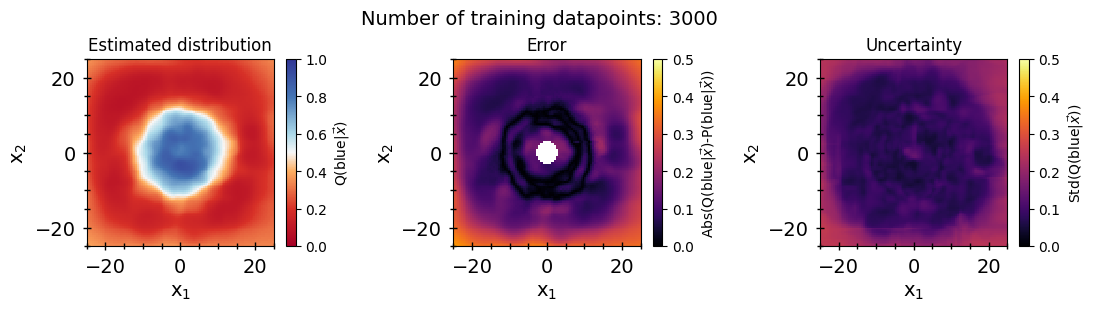

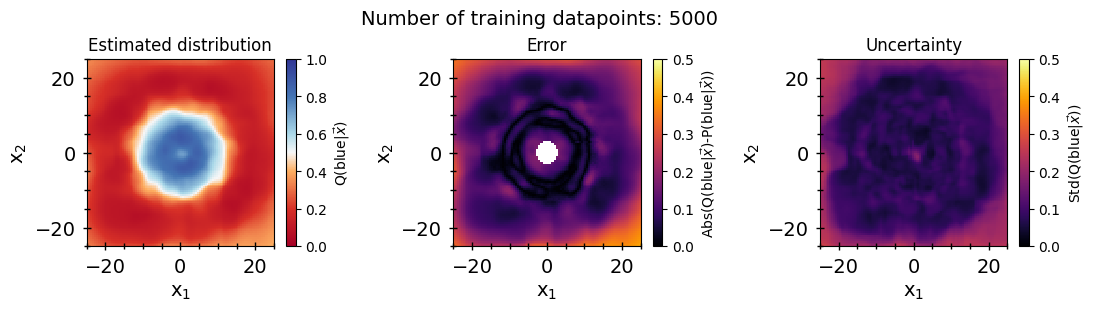

In [9]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_dfs[i], "P(blue|x)", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], truth_data, "P(blue|x)", "P_blue_given_x", axs[1], r"Error")
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=0.5, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap='inferno'), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_samples_blue", axs[2], "Uncertainty", grid=True)
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=0.5, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), label=r"Std(Q(blue|$\vec{x}$))", ax=axs[2])


### Results from inference

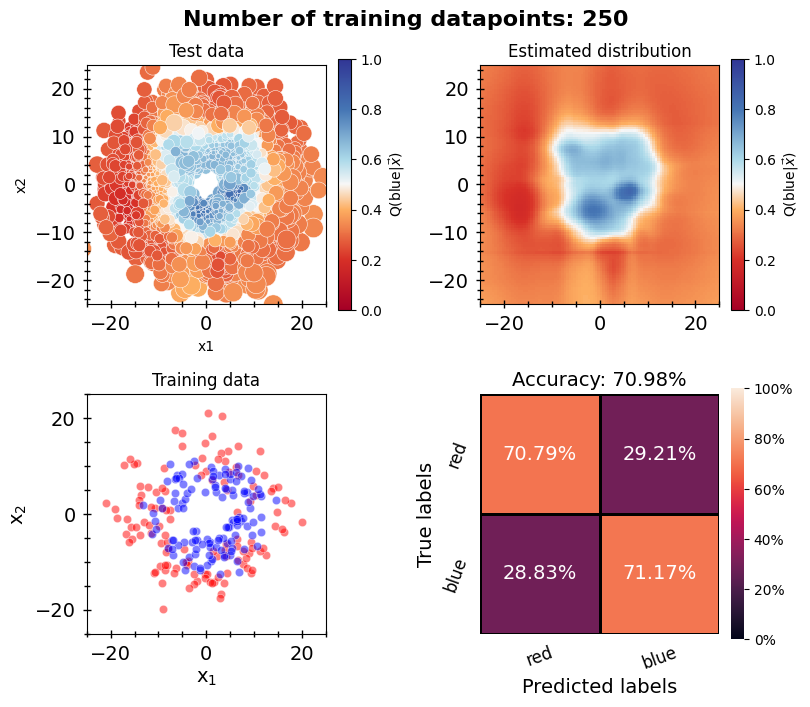

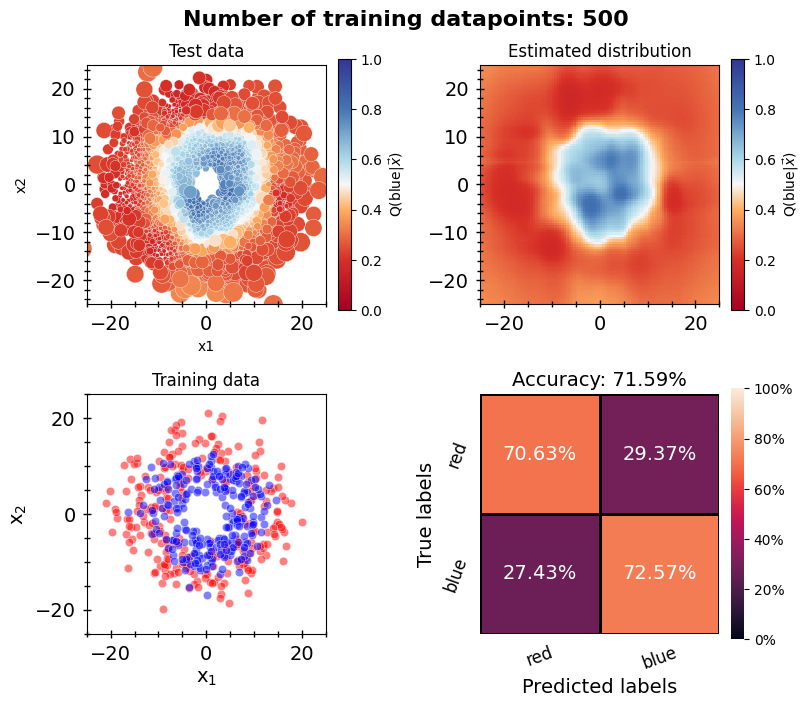

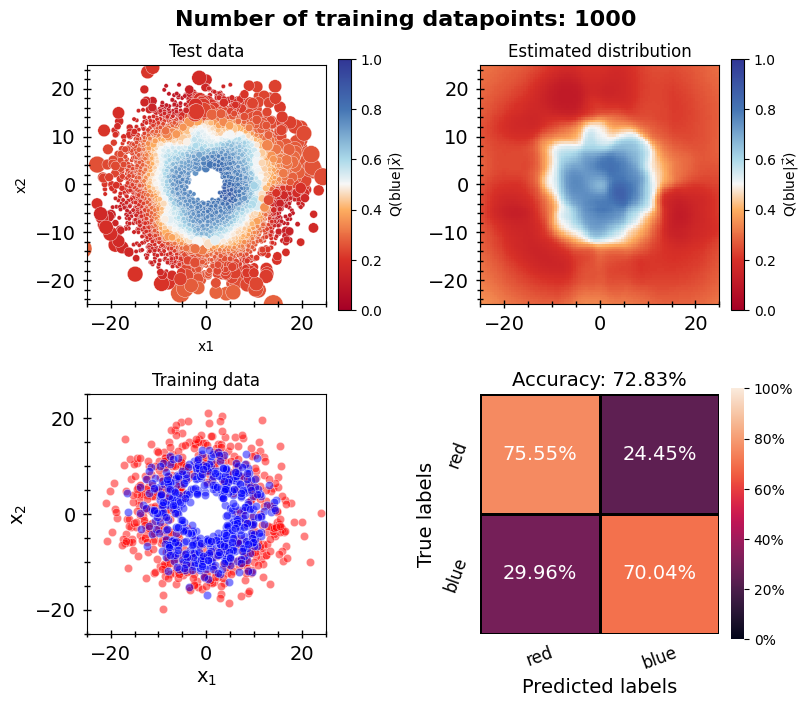

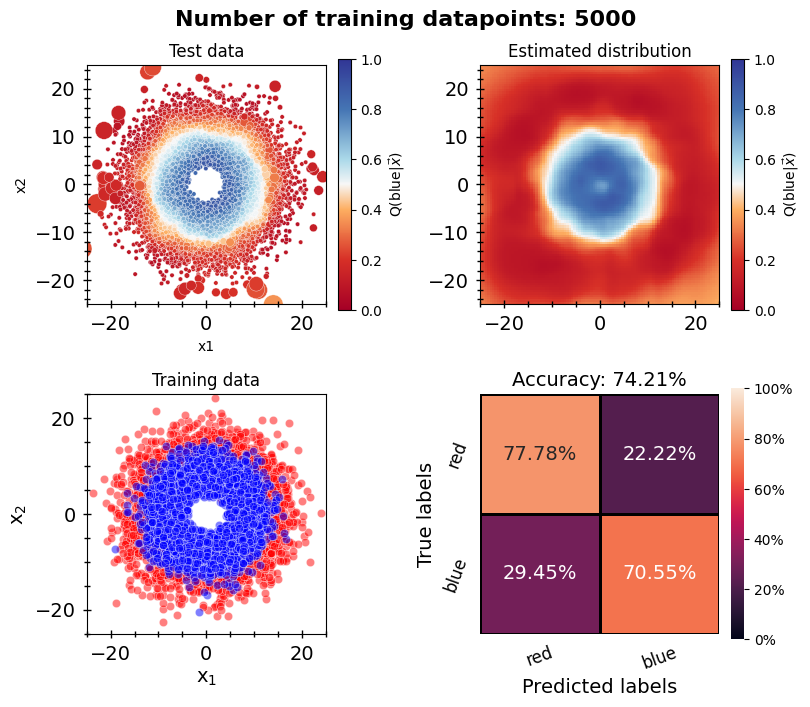

In [39]:

# Plot results

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    
    #plot data
    axs[0][0] = plot_results(test_dfs[i], weight_key, axs[0][0], "Test data")
    axs[0][1] = plot_results(grid_dfs[i], weight_key, axs[0][1], "Estimated distribution", grid=True)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "Truth", "Inferred_color", ["red", "blue"], axs[1][1])
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")
    #plt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

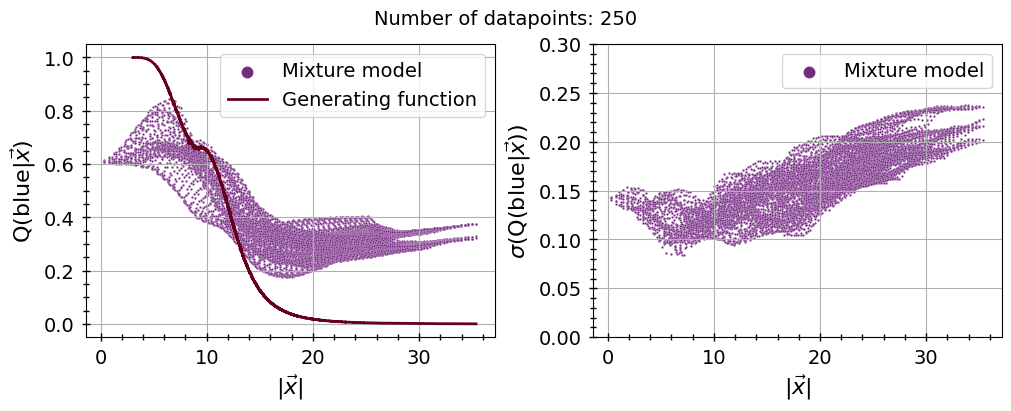

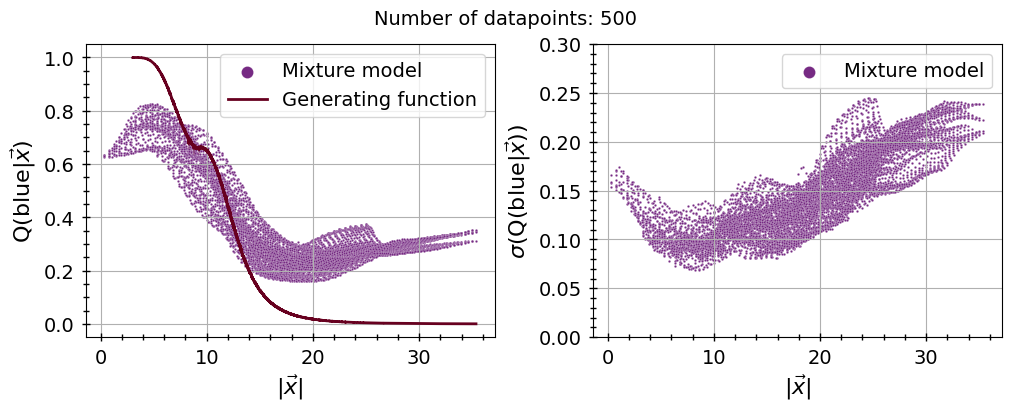

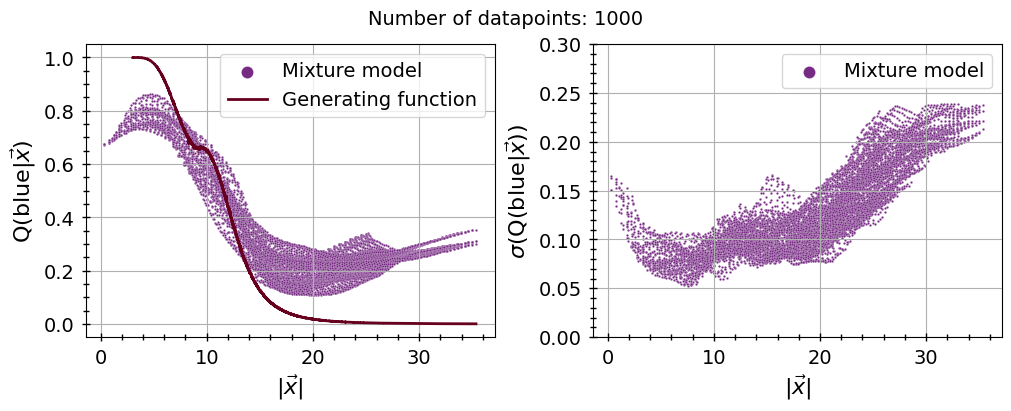

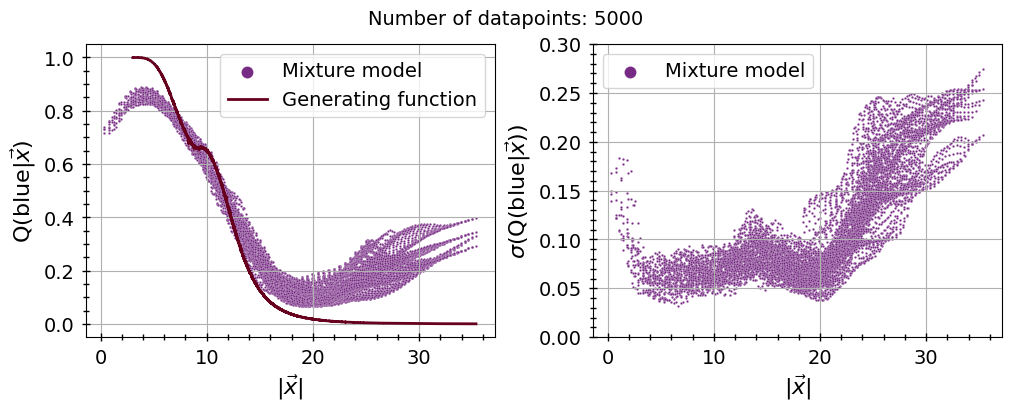

In [40]:
for i in range(n_plots):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="P(blue|x)", s=3, ax = axs[0], label="Mixture model", color="#762a83")
    sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r_x", y="Std_samples_blue", s=3, ax = axs[1], label="Mixture model", color="#762a83")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)


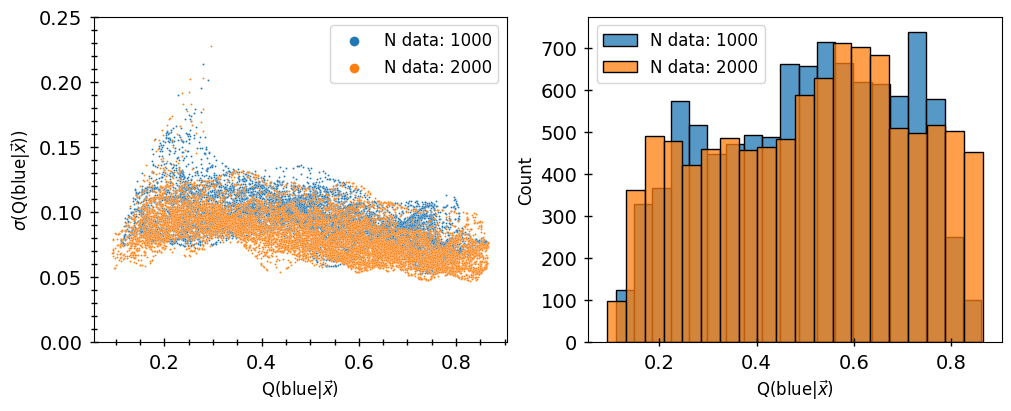

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="P(blue|x)", y="Std_samples_blue", s=2, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs[i], x="P(blue|x)", label=f"N data: {n_data[i]}", ax = axs[1], edgecolor="black", linewidth=1, bins=20)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

Text(0.5, 0, 'N data')

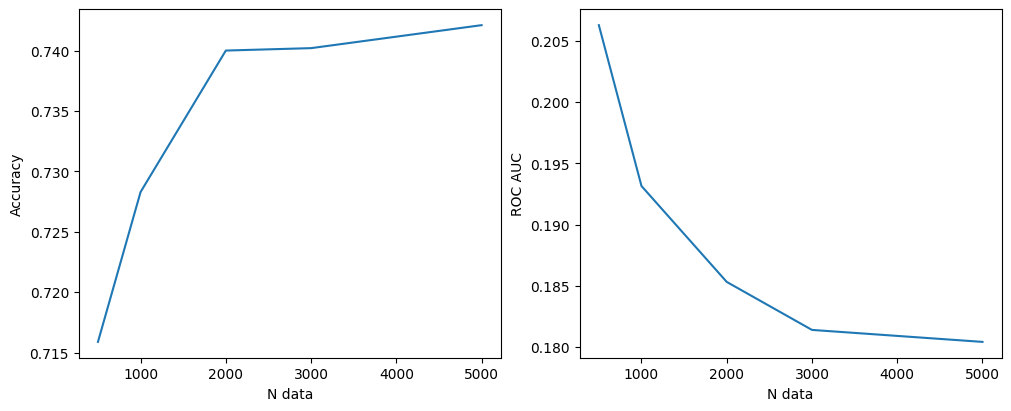

In [24]:

accuracies = [accuracy_score(test_dfs[i]["Truth"], test_dfs[i]["Inferred_color"], normalize=True) for i in range(n_plots)]
roc_auc = [roc_auc_score(test_dfs[i]["Truth"], test_dfs[i]["P(blue|x)"]) for i in range(n_plots)]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
axs[0].plot(n_data, accuracies)
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("N data")

axs[1].plot(n_data, roc_auc)
axs[1].set_ylabel("ROC AUC")
axs[1].set_xlabel("N data")

### Calibration

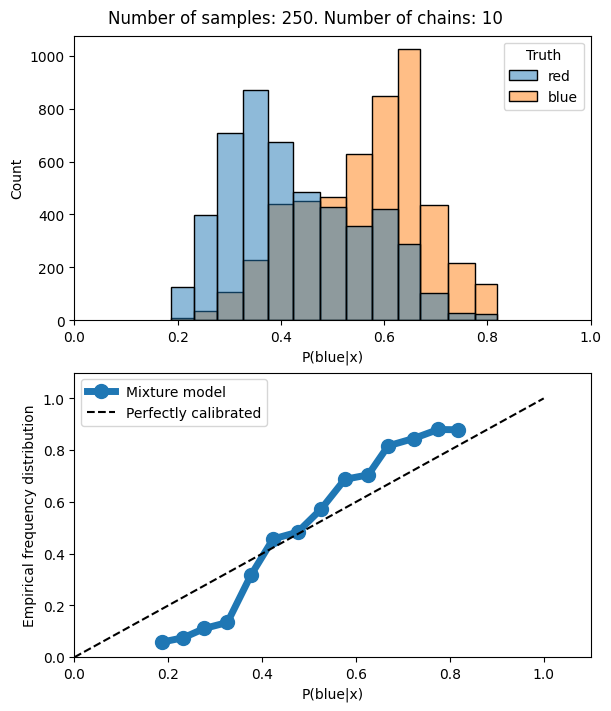

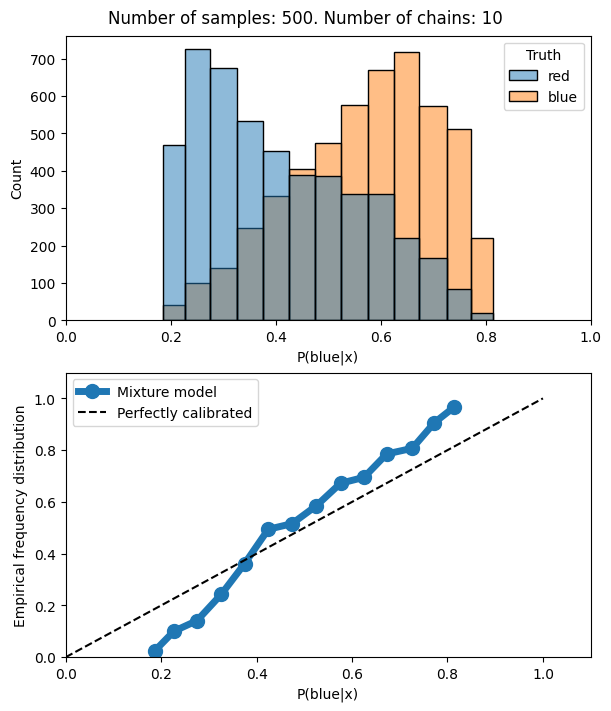

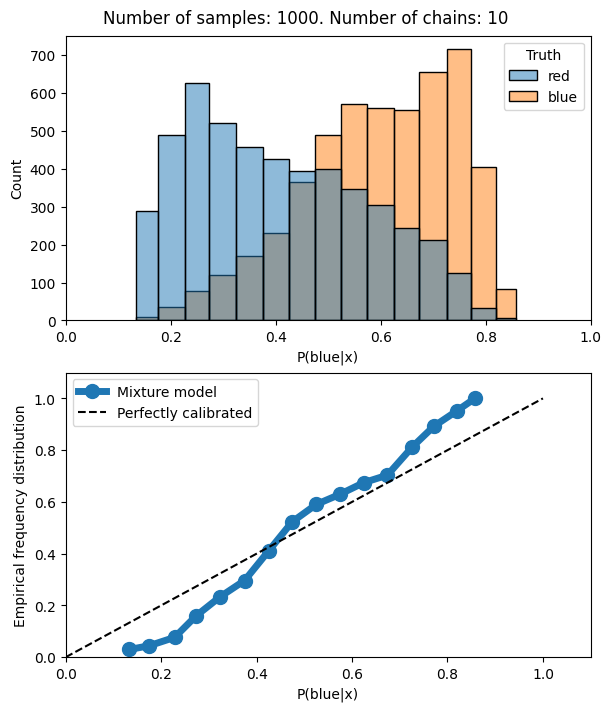

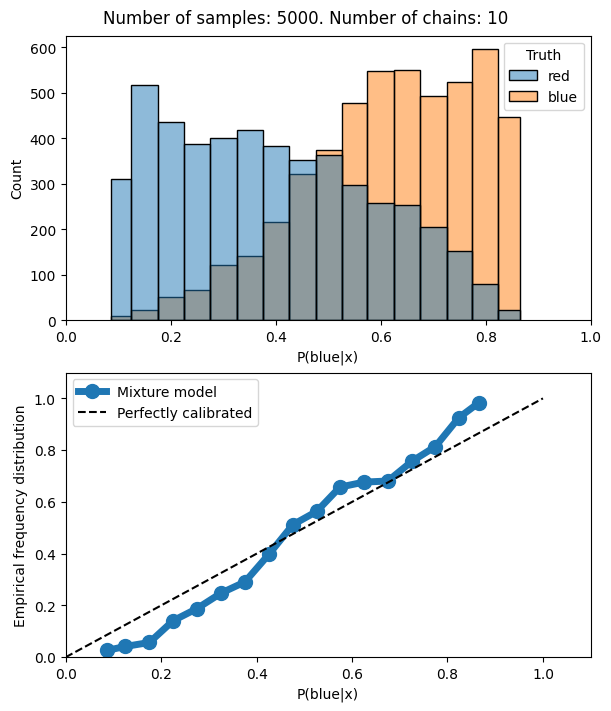

In [42]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(n_plots):
    #Get confidence for red
    prob_cal, prob_pred = calibration_curve(test_dfs[i]["Truth_value"], test_dfs[i]["P(blue|x)"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(test_dfs[i], x="P(blue|x)", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="Mixture model")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of samples: {n_data[i]}. Number of chains: {n_chains}")